In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Standard scaler instance
scaler = StandardScaler()

# Load and drop NaNs
pct_returns_15m = pd.read_csv('pct_returns_15m.csv').dropna().drop(columns=['time','Unnamed: 0'])
pct_returns_1H = pd.read_csv('pct_returns_1H.csv').dropna().drop(columns=['time','Unnamed: 0'])
z_scores_15m = pd.read_csv('zscore_test_15m.csv').dropna().drop(columns=['time','Unnamed: 0'])
z_scores_1H = pd.read_csv('zscore_test_1H.csv').dropna().drop(columns=['time','Unnamed: 0'])

# Dictionary to hold all datasets
datasets = {
    "pct_returns_15m": pct_returns_15m,
    "pct_returns_1H": pct_returns_1H,
    "z_scores_15m": z_scores_15m,
    "z_scores_1H": z_scores_1H
}




In [3]:
print(pct_returns_15m.tail())
print(pct_returns_1H.tail())
print(z_scores_15m.tail())
print(z_scores_1H.tail())

       BTCUSDT   ETHUSDT   BNBUSDT   SOLUSDT   XRPUSDT  DOGEUSDT   TONUSDT  \
7795 -0.000251  0.000868 -0.000148  0.001123  0.000429  0.001965  0.000000   
7796  0.001426  0.001336  0.001446  0.003980  0.000041  0.001274 -0.000626   
7797  0.000270  0.000075  0.000820  0.004616  0.000796  0.001031 -0.001253   
7798 -0.000901 -0.000476 -0.001131  0.001119 -0.001386 -0.002468  0.001254   
7799  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       ADAUSDT  SHIBUSDT  AVAXUSDT  ...  HBARUSDT   FILUSDT   STXUSDT  \
7795  0.001520  0.000767 -0.000266  ...  0.001172  0.000000 -0.000105   
7796  0.002095  0.002636  0.003062  ...  0.003279  0.002869  0.002722   
7797  0.001322  0.000860  0.001991  ...  0.002918  0.000191 -0.000261   
7798 -0.001464 -0.002149 -0.002384  ... -0.000582  0.000000 -0.001566   
7799  0.000000  0.000000  0.000000  ... -0.000699  0.000572  0.002092   

       XLMUSDT   ARBUSDT   IMXUSDT   INJUSDT   WIFUSDT   SUIUSDT   GRTUSDT  
7795  0.002239 

In [8]:
for name, dataset in datasets.items():
    cov_matrix = dataset.cov()
    datasets[name] = cov_matrix
    print(dataset.head())

      BTCUSDT   ETHUSDT   BNBUSDT   SOLUSDT   XRPUSDT  DOGEUSDT   TONUSDT  \
1    0.001189  0.001556  0.001628  0.002197  0.001698  0.001863  0.004248   
2    0.000885  0.000410  0.000484  0.002203  0.000630  0.001265  0.001813   
3   -0.000981 -0.002100  0.000311 -0.001399  0.000532 -0.002091 -0.000603   
4    0.001591  0.002742  0.001572  0.006544  0.003192  0.008829  0.003420   
201  0.001431  0.000302 -0.003503  0.001177 -0.003013 -0.002346 -0.001814   

      ADAUSDT  SHIBUSDT  AVAXUSDT  ...  HBARUSDT   FILUSDT   STXUSDT  \
1   -0.000046  0.000033  0.004452  ...  0.003385  0.001823 -0.002278   
2    0.002658  0.004729  0.000488  ... -0.000606  0.002462  0.008094   
3    0.000735 -0.003791 -0.000380  ...  0.001472 -0.000961  0.004100   
4    0.003108  0.002297  0.004106  ...  0.003803  0.005879 -0.005826   
201 -0.004444 -0.003404 -0.003309  ... -0.001643  0.008826 -0.001877   

      XLMUSDT   ARBUSDT   IMXUSDT   INJUSDT   WIFUSDT   SUIUSDT   GRTUSDT  
1    0.002208  0.001963 -0.0

In [9]:
def run_pca(data, data_name):

    # Standardize the data
    data_scaled = scaler.fit_transform(data)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(data_scaled)

    # Elbow plot for explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance for {data_name} PCA')
    plt.grid(True)
    plt.show()

    return data_scaled, pca_result

def run_clustering(data, pca_result, data_name, n_components, n_clusters):
    
    # Select n_components based on desired explained variance
    principal_components = pca_result[:, :n_components]

    # KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=21)
    clusters = kmeans.fit_predict(pca_result)

    # Create a separate dataframe for clusters
    cluster_df = pd.DataFrame({
        'Asset': data.index,  # Assuming asset identifiers are in the index
        f'Cluster_{n_components}_PC_{n_clusters}_clusters': clusters
    })
    
    # Plot PCA component clusters
    plt.figure(figsize=(10, 7))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', s=50)
    plt.title(f'Clusters of {data_name}_n_components{n_components}_n_clusters{n_clusters} After PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()
    
    return cluster_df

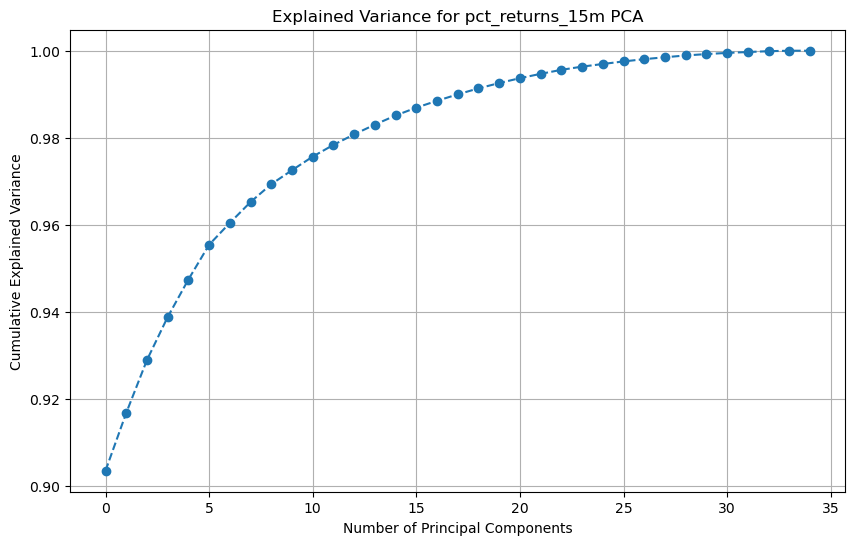

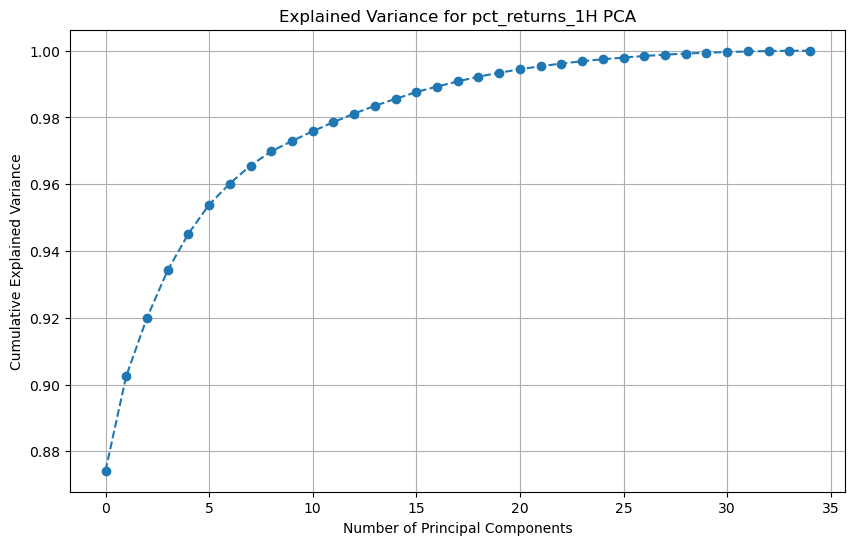

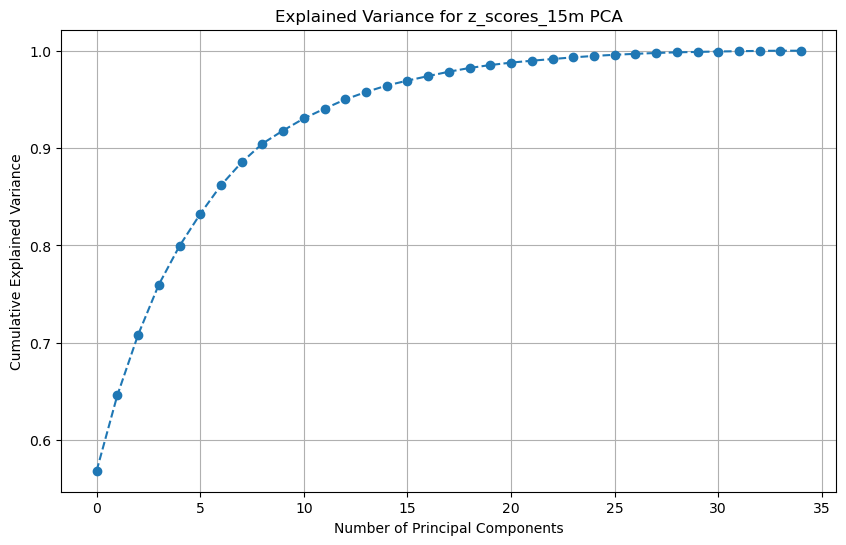

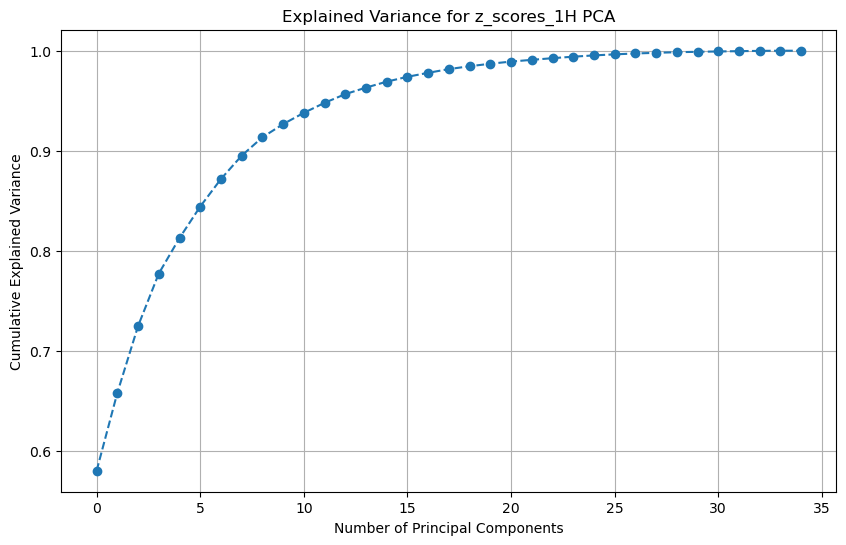

In [10]:
# Run PCA on each dataset and store the scaled data and PCA objects
for name, dataset in datasets.items():
    data_scaled = run_pca(dataset, name)


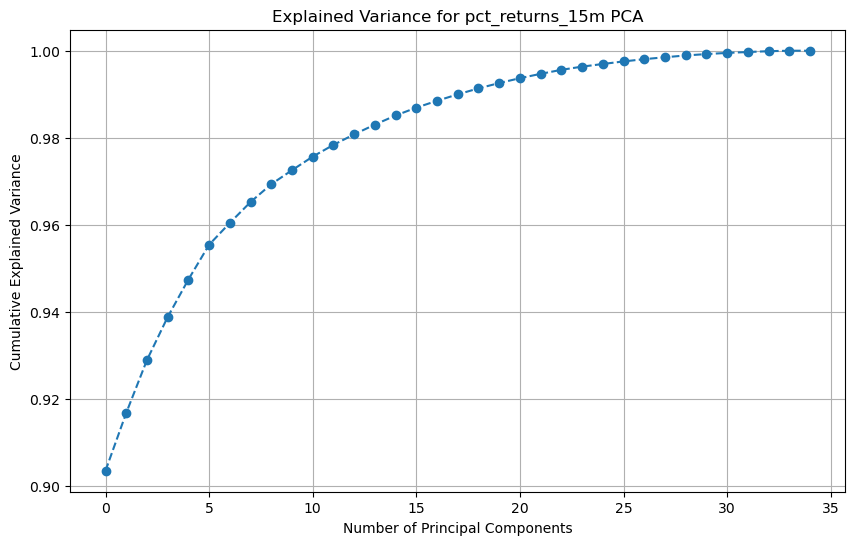

/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


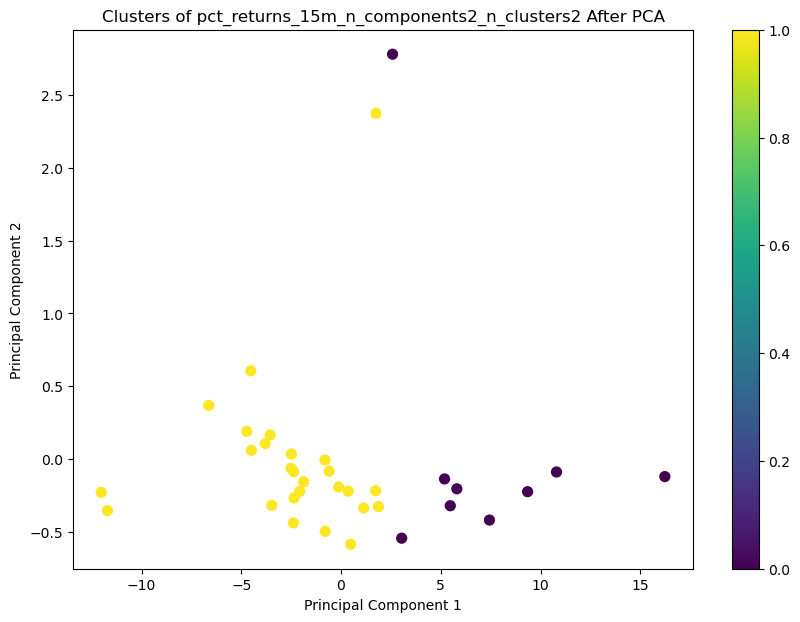

/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


     Asset  Cluster_2_PC_2_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        0
3  SOLUSDT                        1
4  XRPUSDT                        0


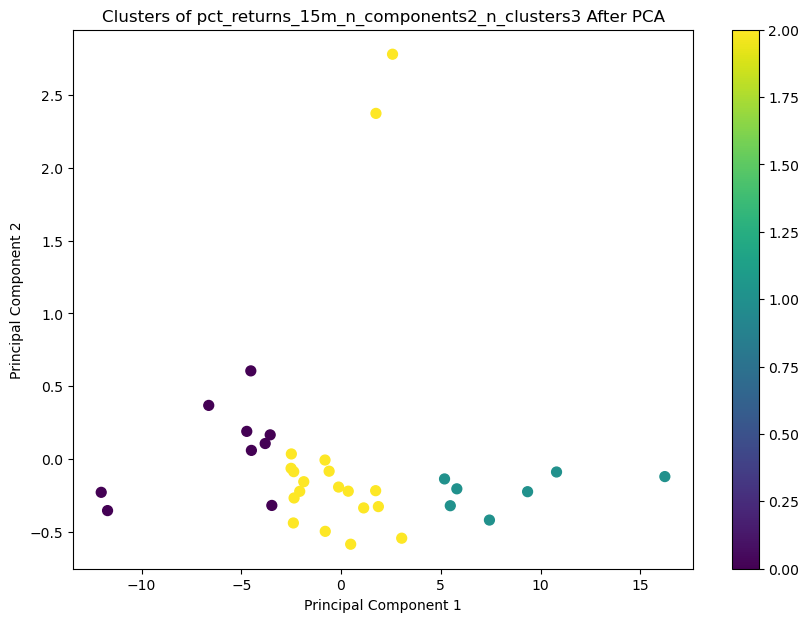

     Asset  Cluster_2_PC_3_clusters
0  BTCUSDT                        1
1  ETHUSDT                        1
2  BNBUSDT                        1
3  SOLUSDT                        2
4  XRPUSDT                        1


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


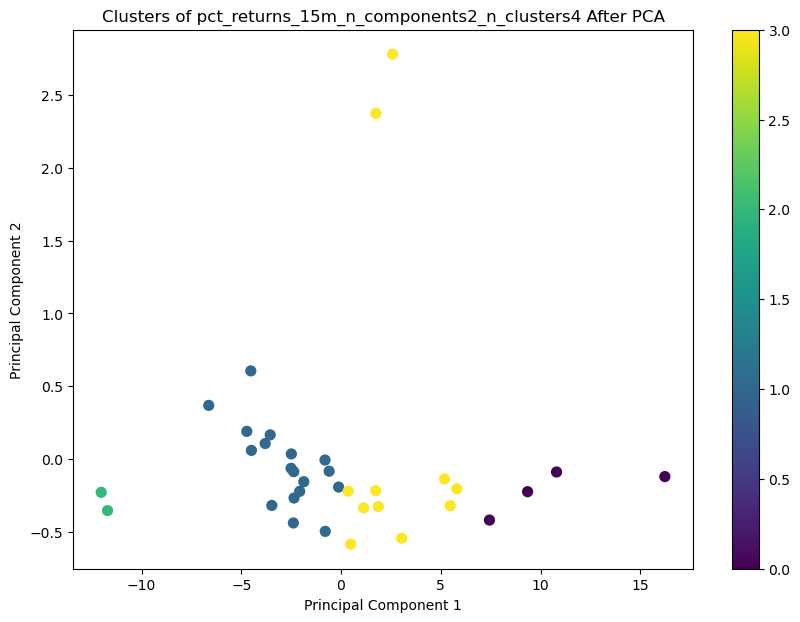

     Asset  Cluster_2_PC_4_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        0
3  SOLUSDT                        1
4  XRPUSDT                        3


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


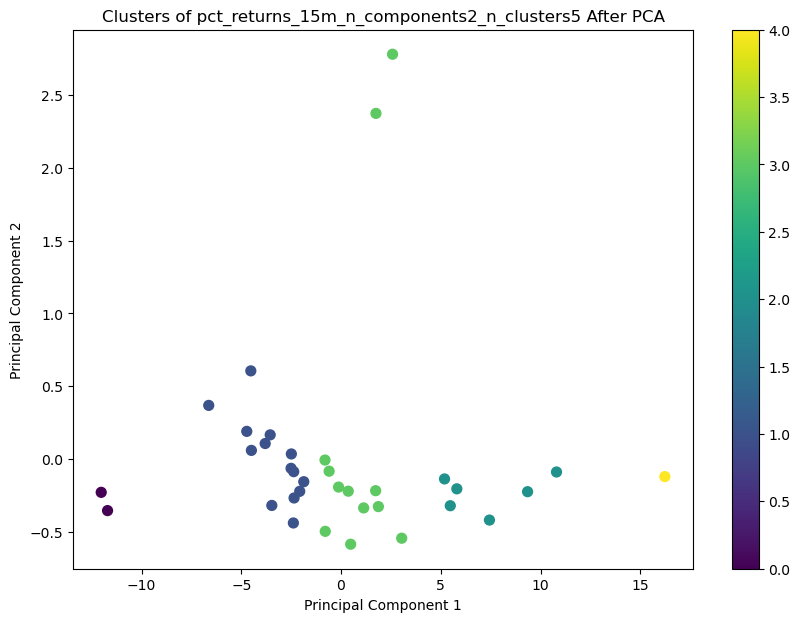

     Asset  Cluster_2_PC_5_clusters
0  BTCUSDT                        2
1  ETHUSDT                        2
2  BNBUSDT                        2
3  SOLUSDT                        3
4  XRPUSDT                        2


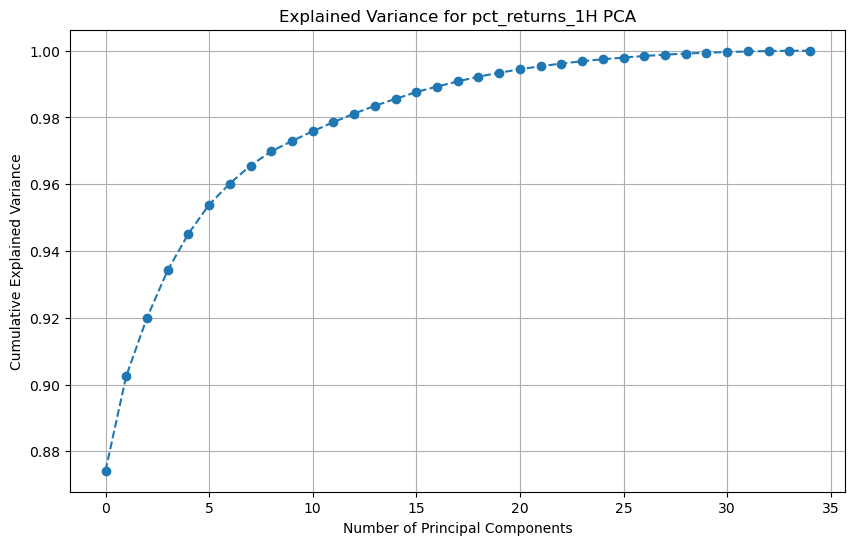

/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


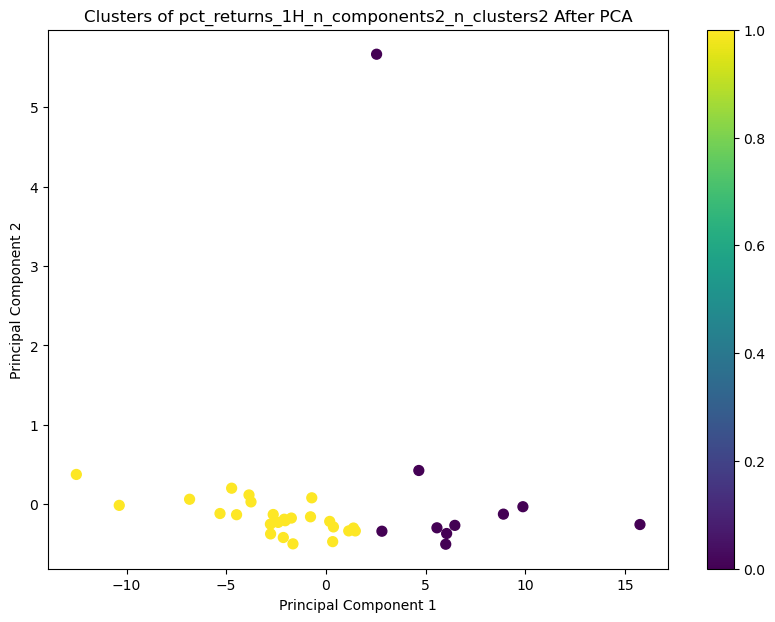

     Asset  Cluster_2_PC_2_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        0
3  SOLUSDT                        1
4  XRPUSDT                        0


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


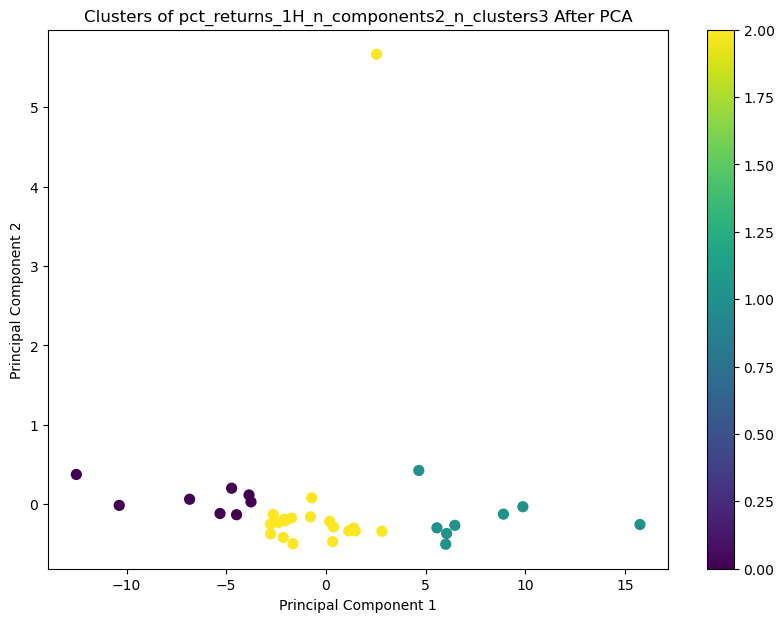

     Asset  Cluster_2_PC_3_clusters
0  BTCUSDT                        1
1  ETHUSDT                        1
2  BNBUSDT                        1
3  SOLUSDT                        2
4  XRPUSDT                        1


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


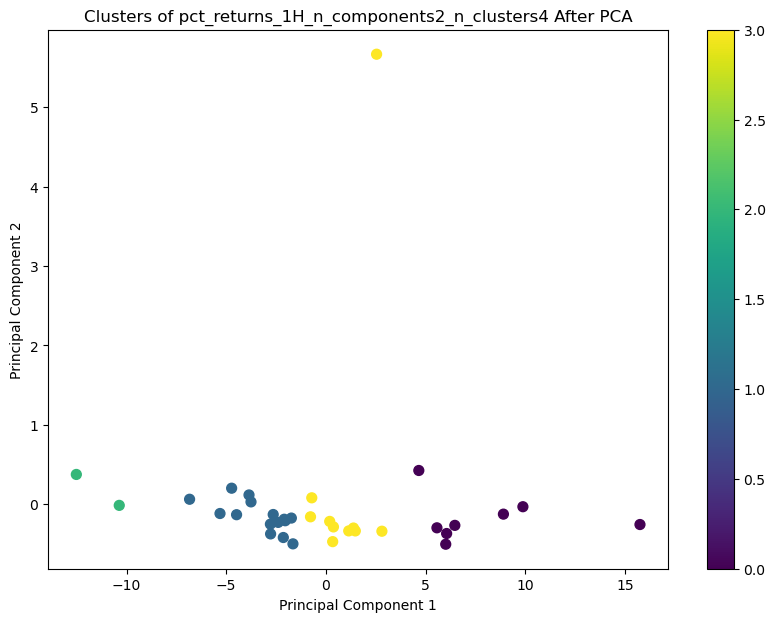

     Asset  Cluster_2_PC_4_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        0
3  SOLUSDT                        3
4  XRPUSDT                        0


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


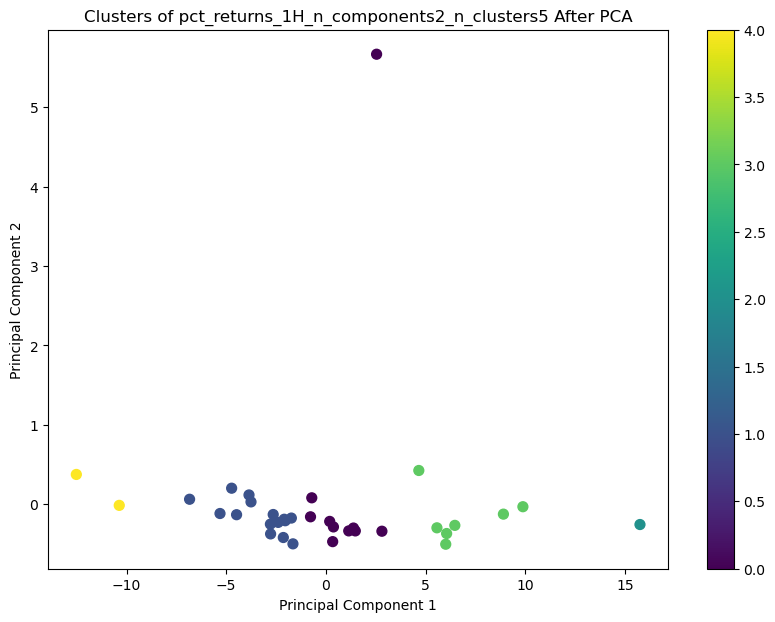

     Asset  Cluster_2_PC_5_clusters
0  BTCUSDT                        3
1  ETHUSDT                        3
2  BNBUSDT                        3
3  SOLUSDT                        0
4  XRPUSDT                        3


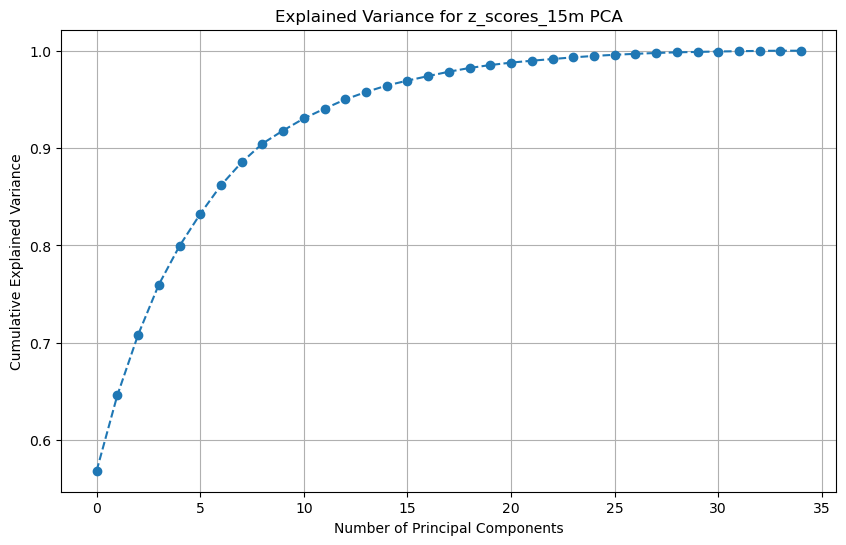

/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


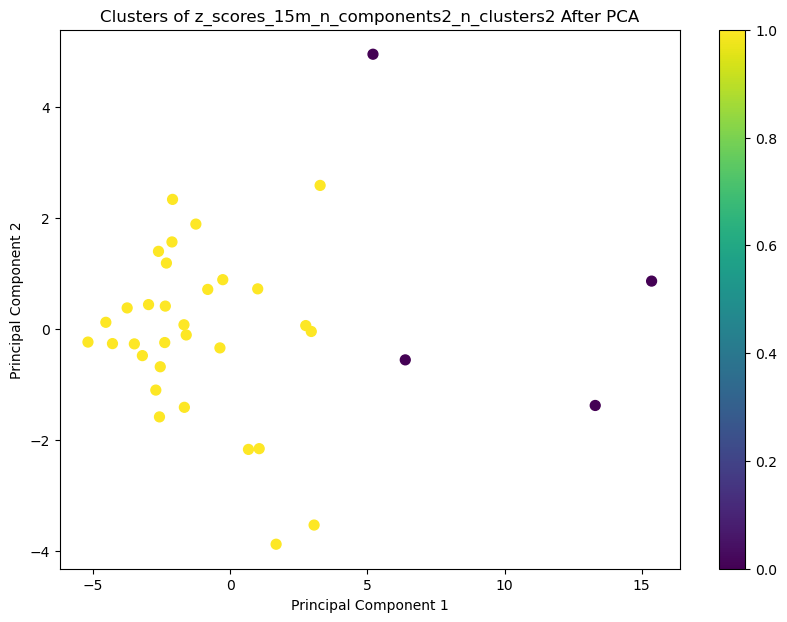

     Asset  Cluster_2_PC_2_clusters
0  BTCUSDT                        1
1  ETHUSDT                        1
2  BNBUSDT                        1
3  SOLUSDT                        1
4  XRPUSDT                        1


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


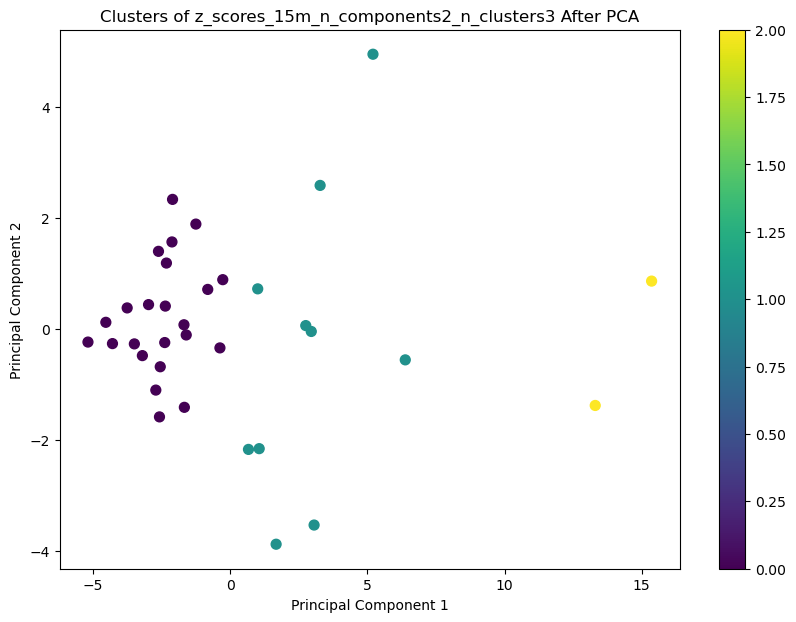

     Asset  Cluster_2_PC_3_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        1
3  SOLUSDT                        0
4  XRPUSDT                        0


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


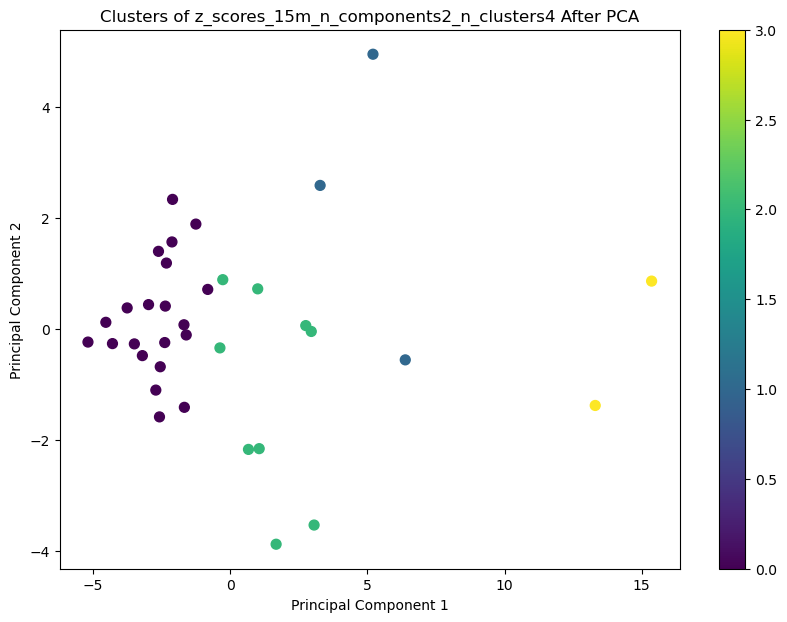

     Asset  Cluster_2_PC_4_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        2
3  SOLUSDT                        0
4  XRPUSDT                        0


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


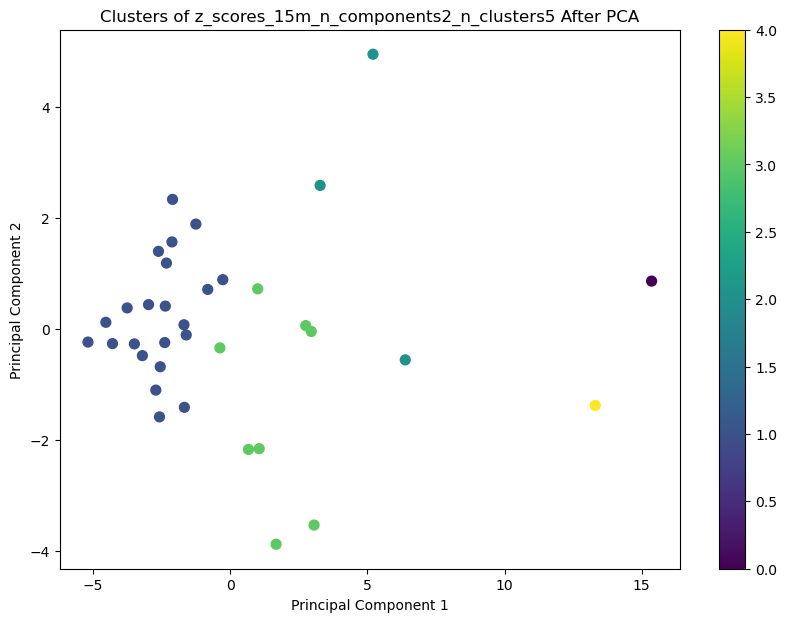

     Asset  Cluster_2_PC_5_clusters
0  BTCUSDT                        1
1  ETHUSDT                        1
2  BNBUSDT                        3
3  SOLUSDT                        1
4  XRPUSDT                        1


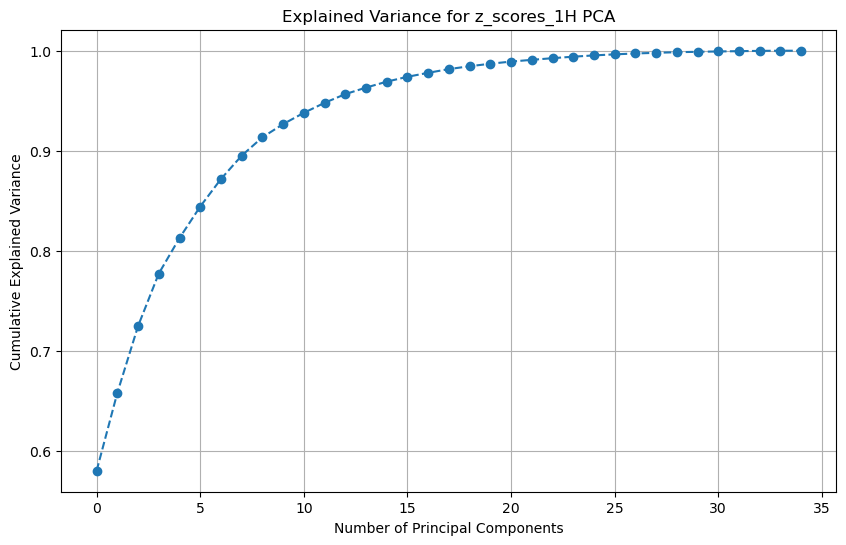

/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


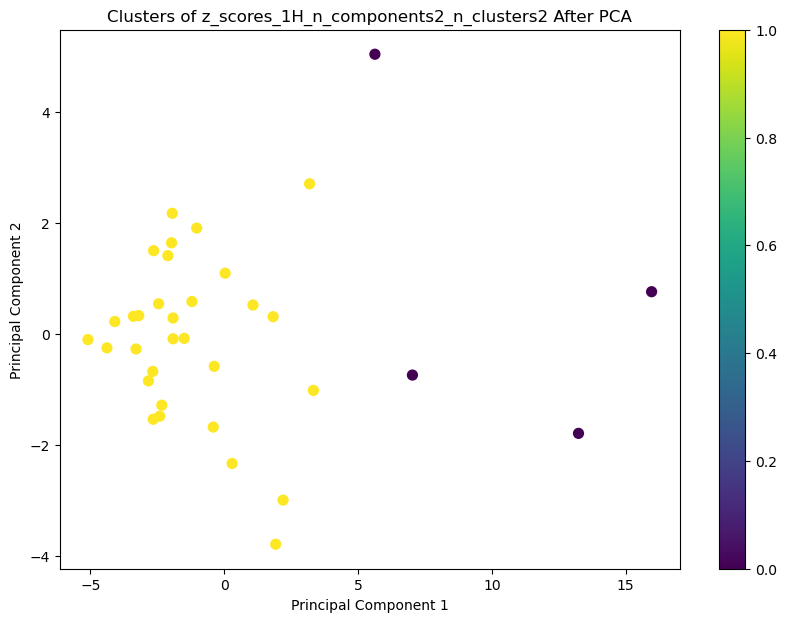

     Asset  Cluster_2_PC_2_clusters
0  BTCUSDT                        1
1  ETHUSDT                        1
2  BNBUSDT                        1
3  SOLUSDT                        1
4  XRPUSDT                        1


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


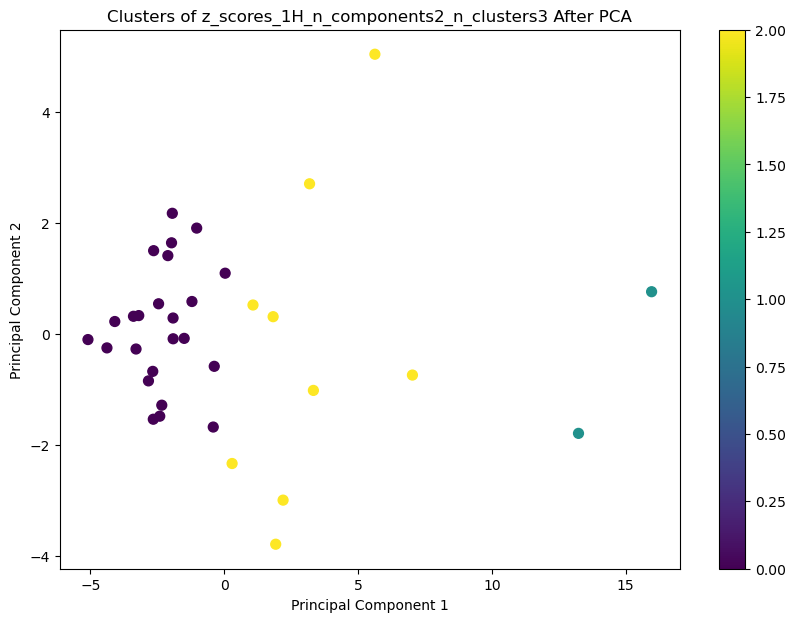

/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


     Asset  Cluster_2_PC_3_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        2
3  SOLUSDT                        0
4  XRPUSDT                        0


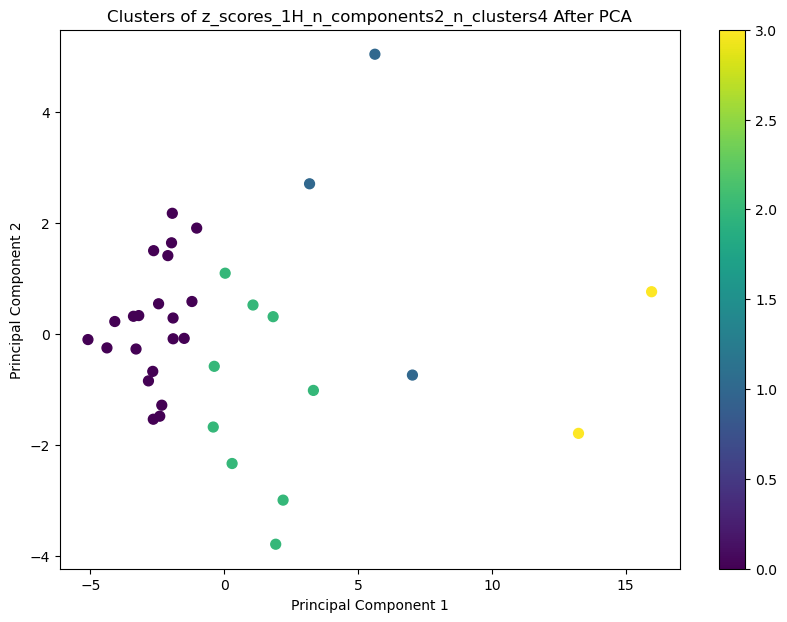

     Asset  Cluster_2_PC_4_clusters
0  BTCUSDT                        0
1  ETHUSDT                        0
2  BNBUSDT                        2
3  SOLUSDT                        0
4  XRPUSDT                        0


/Users/tsharkowill/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


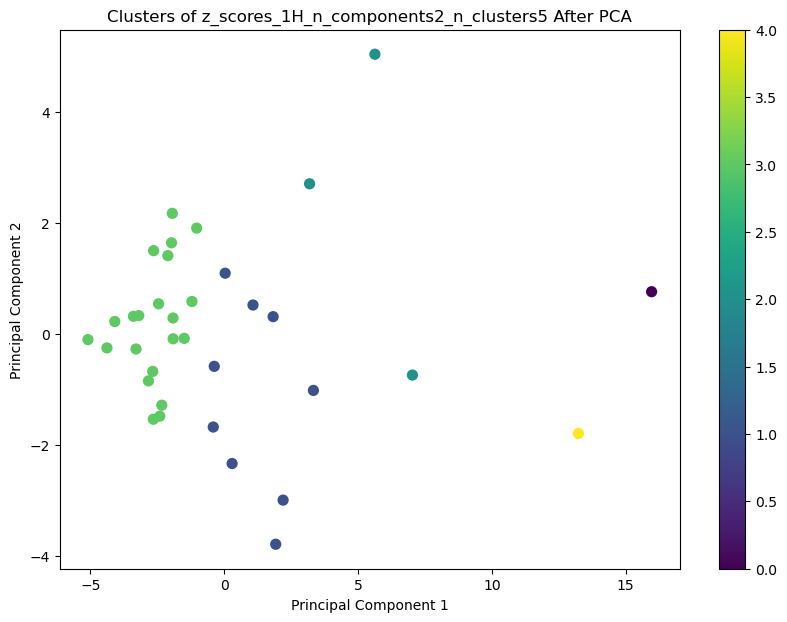

     Asset  Cluster_2_PC_5_clusters
0  BTCUSDT                        3
1  ETHUSDT                        3
2  BNBUSDT                        1
3  SOLUSDT                        3
4  XRPUSDT                        3


In [11]:
# Clustering Parameters
n_components = 2
n_clusters = [2,3,4,5]

# Create a separate dictionary to store the results
clustering_results = {}

# Loop through datasets and Cluster
for name, dataset in datasets.items():
    data_scaled, pca_result = run_pca(dataset, name)
    for clusters in n_clusters:
            # Run clustering with the desired parameters
            cluster_df = run_clustering(dataset, pca_result, name, n_components, clusters)
            print(cluster_df.head())
            
            # Store result in the dictionary with a descriptive key
            key = f'{name}_n_components{n_components}_n_clusters{n_clusters}'
            clustering_results[key] = cluster_df
